In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def remove_outliers(data: pd.Series, min_val: int, max_val: int) -> tuple[pd.Series, pd.Series]:
    """
    Helper function to remove outliers and NaN from a pandas Series
    """
    mask = (data >= min_val) & (data <= max_val)
    data = data.dropna()
    data = data[mask]
    
    return data, mask

In [3]:
data_file = 'data/exp2a.csv'
data = pd.read_csv(data_file)
motor_speed_topic = '/actuators/actuator_1/thruster/motor_state_motor_speed'
current_topic = '/actuators/actuator_1/thruster/motor_state_motor_current'
voltage_topic = '/actuators/actuator_1/thruster/motor_state_battery_voltage'

motor_speed = data[motor_speed_topic]
voltage = data[voltage_topic]
current = data[current_topic]
power = voltage * current

time = np.arange(0, len(data), 1) / 10 # 10 Hz

Number of NaN values in motor_speed: 3098
Number of NaN values in current: 3098
Number of NaN values in voltage: 3098
Number of NaN values in power: 3098


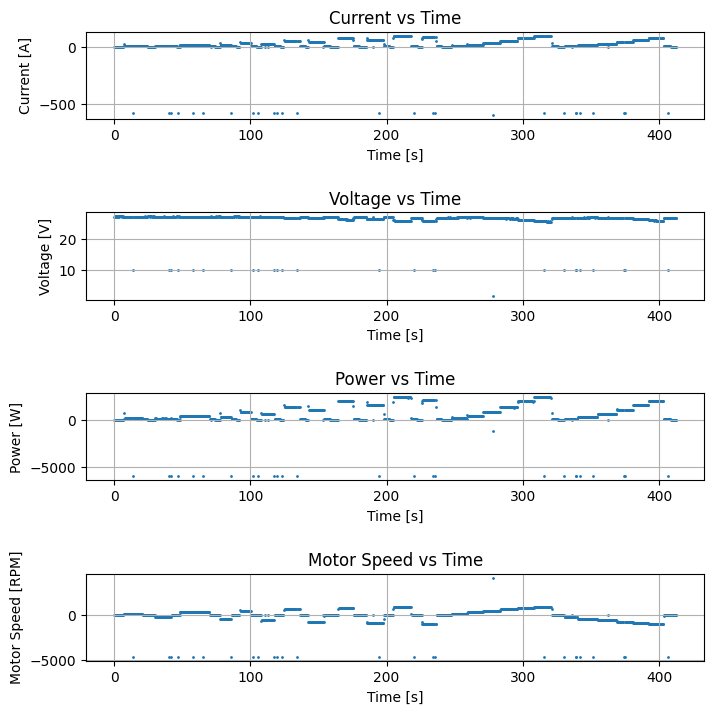

In [4]:
# Plot of raw data
fig, axs = plt.subplots(4, 1, figsize=(7.5, 7.5))

axs[0].scatter(time, current, s=1)
axs[0].grid()
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Current [A]')
axs[0].set_title('Current vs Time')

axs[1].scatter(time, voltage, s=1)
axs[1].grid()
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Voltage [V]')
axs[1].set_title('Voltage vs Time')

axs[2].scatter(time, power, s=1)
axs[2].grid()
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Power [W]')
axs[2].set_title('Power vs Time')

axs[3].scatter(time, motor_speed, s=1)
axs[3].grid()
axs[3].set_xlabel('Time [s]')
axs[3].set_ylabel('Motor Speed [RPM]')
axs[3].set_title('Motor Speed vs Time')

plt.tight_layout(pad=2.0)

num_nan_motor_speed = motor_speed.isna().sum()
num_nan_current = current.isna().sum()
num_nan_voltage = voltage.isna().sum()
num_nan_power = power.isna().sum()
print(f'Number of NaN values in motor_speed: {num_nan_motor_speed}')
print(f'Number of NaN values in current: {num_nan_current}')
print(f'Number of NaN values in voltage: {num_nan_voltage}')
print(f'Number of NaN values in power: {num_nan_power}')

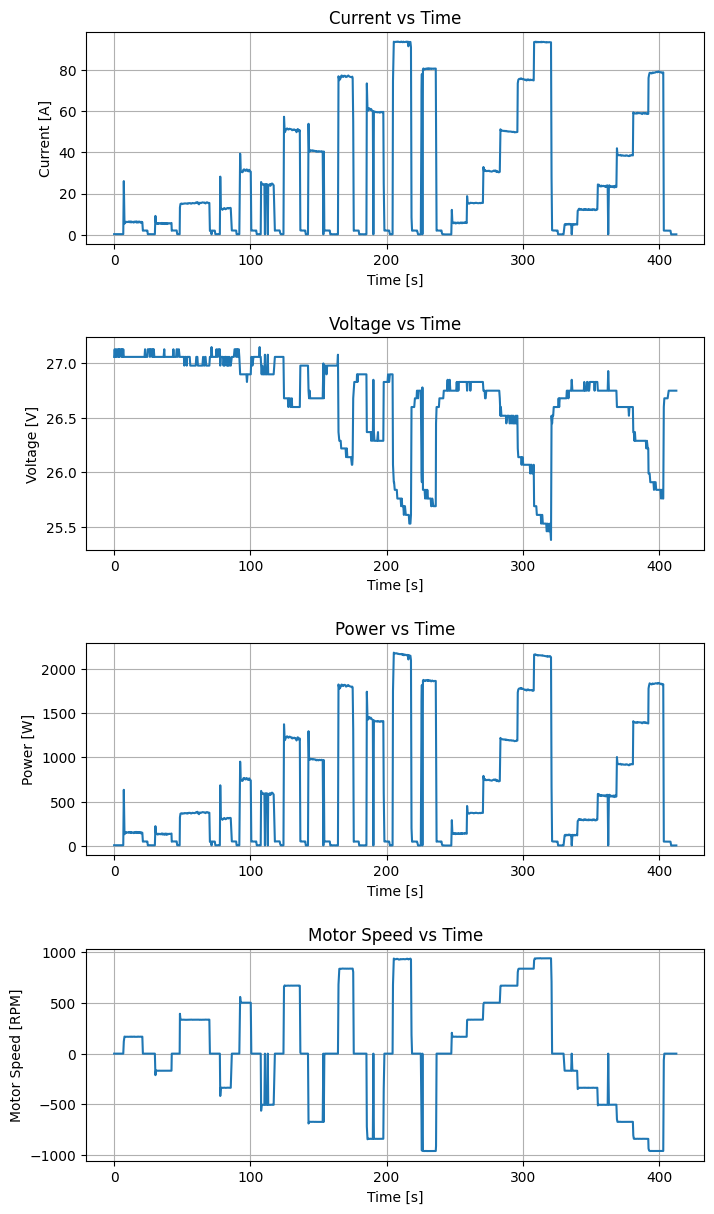

In [5]:
# Remove outliers and NaN
motor_speed_data, mask = remove_outliers(motor_speed, -1000, 1000)
current_data = current[mask]
voltage_data = voltage[mask]

efficiency = 0.9
power_data = power[mask] * efficiency
time_data = time[mask]

# Plot of cleaned data
fig, axs = plt.subplots(4, 1, figsize=(7.5, 12.5))

axs[0].plot(time_data, current_data, markersize=1)
axs[0].grid()
axs[0].set_xlabel('Time [s]')
axs[0].set_ylabel('Current [A]')
axs[0].set_title('Current vs Time')

axs[1].plot(time_data, voltage_data, markersize=1)
axs[1].grid()
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Voltage [V]')
axs[1].set_title('Voltage vs Time')

axs[2].plot(time_data, power_data, markersize=1)
axs[2].grid()
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Power [W]')
axs[2].set_title('Power vs Time')

axs[3].plot(time_data, motor_speed_data, markersize=1)
axs[3].grid()
axs[3].set_xlabel('Time [s]')
axs[3].set_ylabel('Motor Speed [RPM]')
axs[3].set_title('Motor Speed vs Time')

plt.tight_layout(pad=2.0)
plt.show()

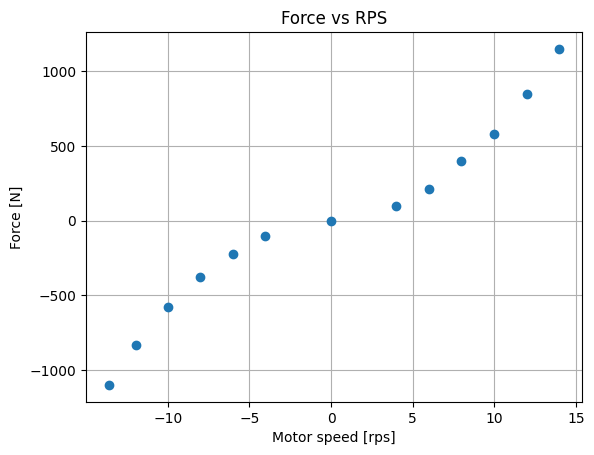

In [6]:
# Force and rpm from Bollard pull test
force = np.array([-1100, -830, -580, -380, -220, -100, 0, 100, 210, 400, 580, 850, 1150])
rpm = np.array([-817, -717, -599, -480, -361, -241, 0, 239, 360, 479, 599, 719, 839])
rps = rpm / 60

plt.figure()
plt.plot(rps, force, 'o')
plt.xlabel('Motor speed [rps]')
plt.ylabel('Force [N]')
plt.title('Force vs RPS')
plt.grid()
plt.show()

Coefficients: [ 5.71777088  2.27320632 -0.3576896 ], [-5.87700454 -0.15633972 -2.85882169]


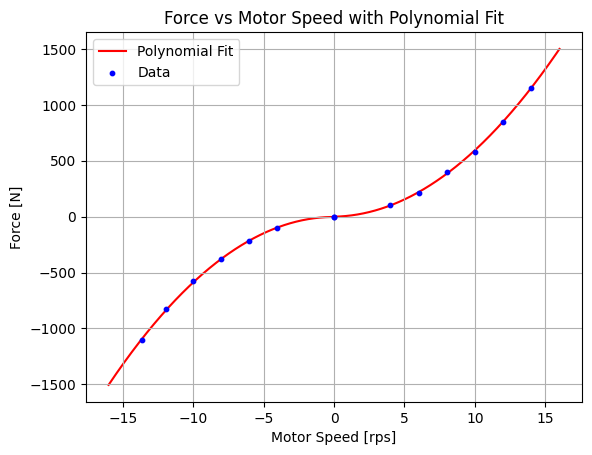

In [7]:
# Splitting data into positive curve and negative curve for more accurate
# polynomial fit
force_plus_mask = force >= 0
force_minus_mask = force <= 0
force_plus = force[force_plus_mask]
force_minus = force[force_minus_mask]
rps_plus = rps[force_plus_mask]
rps_minus = rps[force_minus_mask]

# Polynomial fit
force_coefficients = np.polyfit(rps_plus, force_plus, 2)
force_polynomial = np.poly1d(force_coefficients)
rps_plus_fit = np.linspace(0, 16, 500)
force_plus_fit = force_polynomial(rps_plus_fit)

force_coefficients_neg = np.polyfit(rps_minus, force_minus, 2)
force_polynomial_neg = np.poly1d(force_coefficients_neg)
rps_minus_fit = np.linspace(-16, 0, 500)
force_minus_fit = force_polynomial_neg(rps_minus_fit)

print(f"Coefficients: {force_coefficients}, {force_coefficients_neg}")


plt.figure()
plt.plot(rps_plus_fit, force_plus_fit, color='red', label='Polynomial Fit', zorder=1)
plt.scatter(rps_plus, force_plus, s=10, label='Data', color='blue', zorder=2)
plt.plot(rps_minus_fit, force_minus_fit, color='red', zorder=1)
plt.scatter(rps_minus, force_minus, s=10, color='blue', zorder=2)
plt.xlabel('Motor Speed [rps]')
plt.ylabel('Force [N]')
plt.title('Force vs Motor Speed with Polynomial Fit')
plt.legend()
plt.grid()
plt.show()

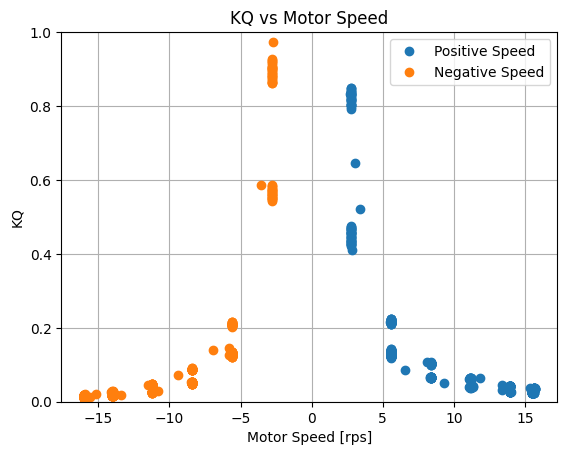

In [8]:
D = 0.3 # Diameter of propeller in meters
rho = 1025 # Density of water in kg/m^3
motor_speed_data_rps = motor_speed_data / 60
Q = power_data / (2 * np.pi * motor_speed_data_rps)
KQ = Q / (D**5 * rho * abs(motor_speed_data_rps) * motor_speed_data_rps)

pos_speed_mask = motor_speed_data_rps >= 0
neg_speed_mask = motor_speed_data_rps <= 0

Q_plus = Q[pos_speed_mask]
Q_minus = Q[neg_speed_mask]
speed_plus = motor_speed_data_rps[pos_speed_mask]
speed_minus = motor_speed_data_rps[neg_speed_mask]
Pm_plus = power_data[pos_speed_mask]
Pm_minus = power_data[neg_speed_mask]

# clean data
Q_plus_valid_mask = Q_plus < 30
Q_plus = Q_plus[Q_plus_valid_mask]
speed_plus = speed_plus[Q_plus_valid_mask]
Pm_plus_original = Pm_plus[Q_plus_valid_mask]

Q_minus_valid_mask = (Q_minus > -20) & (Q_minus < 0)
Q_minus = Q_minus[Q_minus_valid_mask]
speed_minus = speed_minus[Q_minus_valid_mask]
Pm_minus_original = Pm_minus[Q_minus_valid_mask]

Q_plus_datapoints = len(Q_plus)
Q_minus_datapoints = len(Q_minus)

# Polynomial fit
Q_plus_coefficients = np.polyfit(speed_plus, Q_plus, 2)
Q_plus_polynomial = np.poly1d(Q_plus_coefficients)
speed_plus_fit = np.linspace(min(speed_plus), max(speed_plus), Q_plus_datapoints)
Q_plus_fit = Q_plus_polynomial(speed_plus_fit)

Q_minus_coefficients = np.polyfit(speed_minus, Q_minus, 2)
Q_minus_polynomial = np.poly1d(Q_minus_coefficients)
speed_minus_fit = np.linspace(min(speed_minus), max(speed_minus), Q_minus_datapoints)
Q_minus_fit = Q_minus_polynomial(speed_minus_fit)

KQ_plus = Q_plus_fit / (D**5 * rho * speed_plus**2)
KQ_plus_const = 0.04
Q_plus_simplyfied = KQ_plus_const * D**5 * rho * speed_plus**2

KQ_minus = -Q_minus_fit / (D**5 * rho * speed_minus**2)
KQ_minus_const = 0.04
Q_minus_simplyfied = -KQ_minus_const * D**5 * rho * speed_minus**2

# Pm_plus = 2 * np.pi * speed_plus * Q_plus_fit
# Pm_minus = 2 * np.pi * speed_minus * Q_minus_fit

plt.figure()
plt.plot(speed_plus, KQ_plus, 'o', label='Positive Speed')
plt.plot(speed_minus, KQ_minus, 'o', label='Negative Speed')
plt.xlabel('Motor Speed [rps]')
plt.ylabel('KQ')
plt.title('KQ vs Motor Speed')
plt.legend()
plt.ylim(0, 1)
plt.grid()
plt.show()

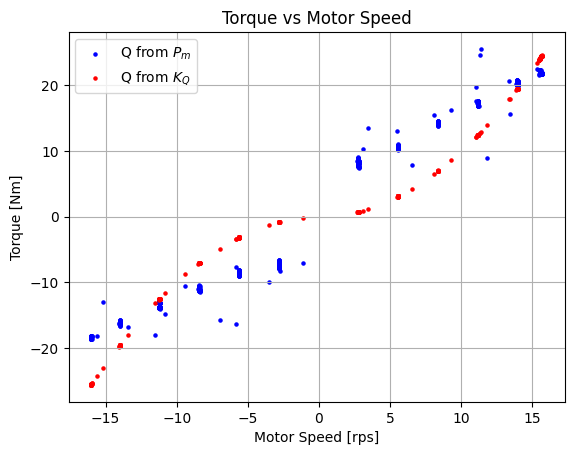

In [9]:
plt.figure()
plt.scatter(speed_plus, Q_plus, s=5, color='blue', label=r'Q from $P_{m}$')
plt.scatter(speed_minus, Q_minus, s=5, color='blue')
plt.scatter(speed_plus, Q_plus_simplyfied, s=5, color='red', label=r'Q from $K_{Q}$')
plt.scatter(speed_minus, Q_minus_simplyfied, s=5, color='red')
plt.xlabel('Motor Speed [rps]')
plt.ylabel('Torque [Nm]')
plt.title('Torque vs Motor Speed')
plt.legend()
plt.grid()

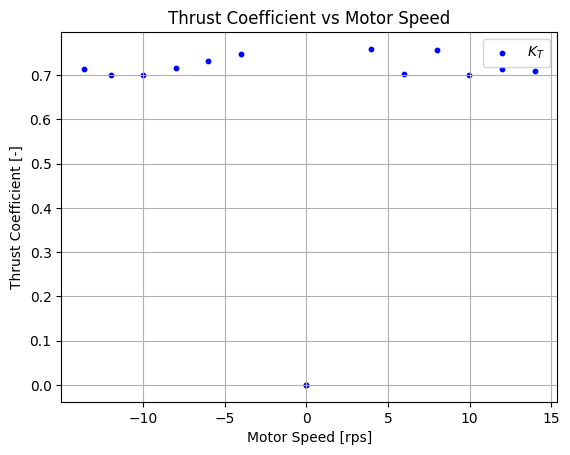

In [10]:
KT_plus = force_plus / (D**4 * rho * rps_plus**2 + 0.0001)
KT_plus_const = 0.72
KT_minus = -force_minus / (D**4 * rho * rps_minus**2 + 0.0001)
KT_minus_const = 0.72

plt.figure()
plt.scatter(rps_plus, KT_plus, s=10, color='blue', label=r'$K_{T}$')
plt.scatter(rps_minus, KT_minus, s=10, color='blue')
# plt.ylim(0, 1)
plt.xlabel('Motor Speed [rps]')
plt.ylabel('Thrust Coefficient [-]')
plt.title('Thrust Coefficient vs Motor Speed')
plt.legend()
plt.grid()

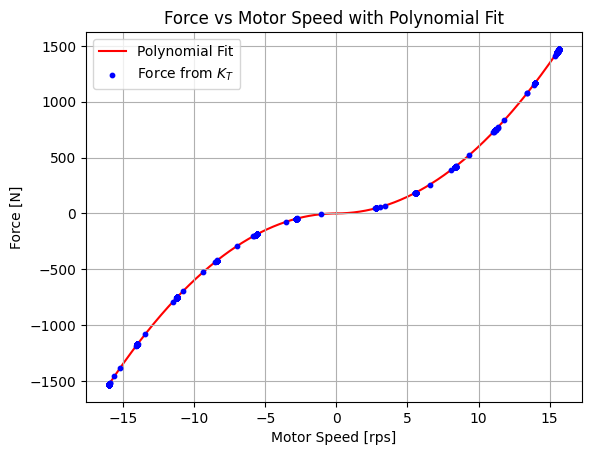

In [11]:
force_from_KT_plus = KT_plus_const * rho * D**4 * speed_plus**2
force_from_KT_minus = -KT_minus_const * rho * D**4 * speed_minus**2

# Polynomial fit
force_from_KT_plus_coefficients = np.polyfit(speed_plus, force_from_KT_plus, 2)
force_from_KT_plus_polynomial = np.poly1d(force_from_KT_plus_coefficients)
rps_plus_fit = np.linspace(0, max(speed_plus), 500)
force_from_KT_plus_fit = force_from_KT_plus_polynomial(rps_plus_fit)

force_from_KT_minus_coefficients = np.polyfit(speed_minus, force_from_KT_minus, 2)
force_from_KT_minus_polynomial = np.poly1d(force_from_KT_minus_coefficients)
rps_minus_fit = np.linspace(min(speed_minus), 0, 500)
force_from_KT_minus_fit = force_from_KT_minus_polynomial(rps_minus_fit)

plt.figure()
plt.plot(rps_plus_fit, force_from_KT_plus_fit, color='red', label='Polynomial Fit', zorder=1)
plt.scatter(speed_plus, force_from_KT_plus, s=10, label=r'Force from $K_T$', color='blue', zorder=2)
plt.plot(rps_minus_fit, force_from_KT_minus_fit, color='red', zorder=1)
plt.scatter(speed_minus, force_from_KT_minus, s=10, color='blue', zorder=2)
plt.plot()
plt.xlabel('Motor Speed [rps]')
plt.ylabel('Force [N]')
plt.title('Force vs Motor Speed with Polynomial Fit')
plt.legend()
plt.grid()
plt.show()

C:\Users\ahoeg\AppData\Local\Temp\ipykernel_40872\1695742598.py:1: RuntimeWarning: invalid value encountered in power
  power_from_force_plus = 2 * np.pi * KQ_plus_const * force_plus_fit**1.5 / (D * rho**0.5 * KT_plus_const**1.5)


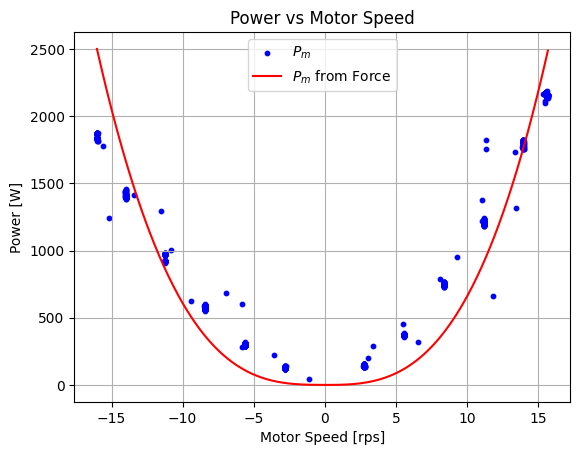

In [12]:
power_from_force_plus = 2 * np.pi * KQ_plus_const * force_plus_fit**1.5 / (D * rho**0.5 * KT_plus_const**1.5)
power_from_force_minus = 2 * np.pi * KQ_minus_const * abs(force_minus_fit)**1.5 / (D * rho**0.5 * KT_minus_const**1.5)

plt.figure()
plt.scatter(speed_plus, Pm_plus_original, s=10, color='blue', label=r'$P_{m}$')
plt.scatter(speed_minus, Pm_minus_original, s=10, color='blue')
plt.plot(rps_plus_fit, power_from_force_plus, color='red', label=r'$P_{m}$ from Force')
plt.plot(rps_minus_fit, power_from_force_minus, color='red')
plt.xlabel('Motor Speed [rps]')
plt.ylabel('Power [W]')
plt.title('Power vs Motor Speed')
plt.legend()
plt.grid()